Let's prepare some data:

In [13]:
import pandas as pd

df = pd.read_json("export/data/apps.json").T

df["star_average"] = ((1 * df["star1"]) + 
(2 * df["star2"]) + 
(3 * df["star3"]) + 
(4 * df["star4"]) + 
(5 * df["star5"])) / (df["star1"] + df["star2"] + df["star3"] + df["star4"] + df["star5"])

reviewsDf = pd.read_json("export/data/reviews.json")


Let's look how apps are rated:

<AxesSubplot:ylabel='Distribution of ratings'>

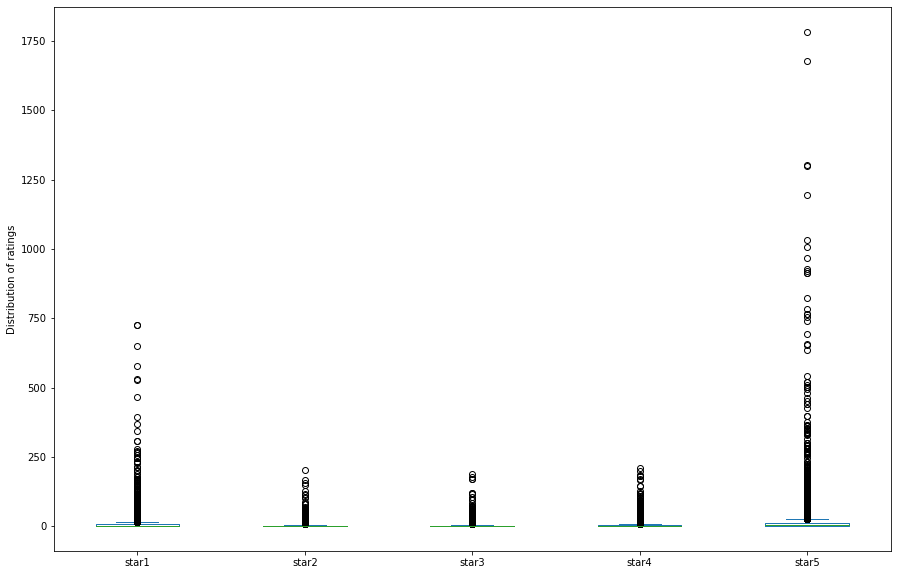

In [14]:
df[["star1", "star2", "star3", "star4", "star5"]].plot.box(ylabel="Distribution of ratings", figsize=(15, 10))

So it seems like there are far more apps with one stars and five stars then everything else. Not very suprising so far.

So let's look at the raw data and figure out what the mean for each rating is.

<AxesSubplot:>

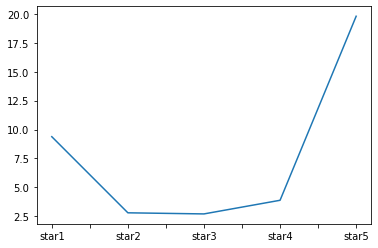

In [15]:
df[["star1", "star2", "star3", "star4", "star5"]].mean().plot()

So the average rating of the apps in the linux ecosystem is around 3.5

<AxesSubplot:>

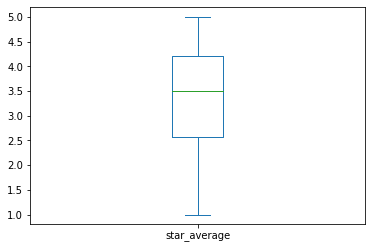

In [16]:
df["star_average"].plot.box()

Have a look at the top rated apps:

In [17]:
df[df["total"]>20].dropna().nlargest(20,"star_average")["star_average"]

org.speedcrunch.SpeedCrunch                                     4.962963
speedcrunch.desktop                                             4.962963
io.snapcraft.mapscii-YmktiCRE0Dg3FvsSwXiNFHeygSzRtyIo           4.909091
sublime_text.desktop                                            4.906250
PersianCalendar@oxygenws.com.shell-extension                    4.875000
PersianCalendar_oxygenws.com                                    4.875000
unite_hardpixel.eu                                              4.869565
com.rafaelmardojai.Blanket                                      4.868421
com.shatteredpixel.shatteredpixeldungeon                        4.857143
dash-to-panel_jderose9.github.com                               4.850829
org.kde.plasmashell                                             4.850746
sound-output-device-chooser_kgshank.net                         4.842105
Internet-Speed-Meter_TH3L0N3C0D3R                               4.800000
gnome-tweak-tool.desktop                           

Which distros are these reviews coming from?

<AxesSubplot:>

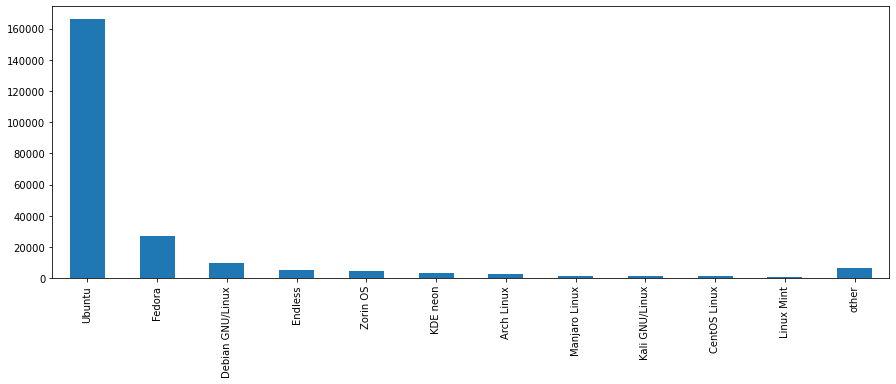

In [18]:
prob = reviewsDf["distro"].value_counts()

mask = prob > 1000
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar', figsize=(15, 5))

Which languages are these reviews in?

<AxesSubplot:>

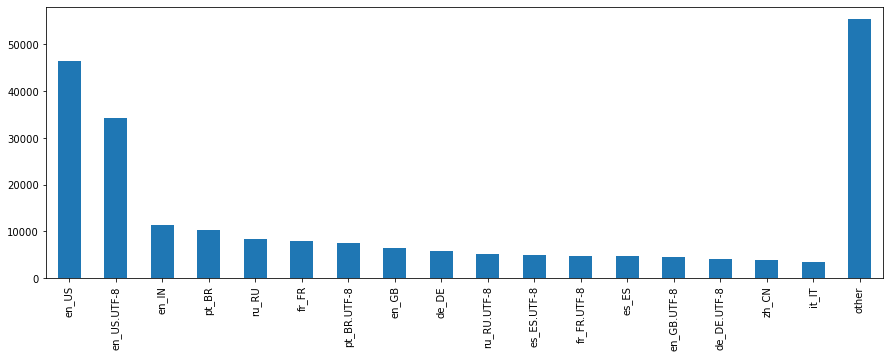

In [19]:
prob = reviewsDf["locale"].value_counts()

mask = prob > 3000
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar', figsize=(15, 5))